In [1]:
import pathlib

import cmocean.cm
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.interpolate

%matplotlib inline

In [2]:
url = pathlib.Path('~/Downloads/xband_resolution_200m_2016.nc').expanduser()

In [3]:
ds = netCDF4.Dataset(str(url))

In [4]:
lat = ds.variables['Lat'][0]
lon = ds.variables['Lon'][0]
times = netCDF4.num2date(ds.variables['Time'][:], ds.variables['Time'].units)

In [5]:
def resample(arr, scale=1, fill_value=0.0, k=2):
    
    mask = hasattr(arr, 'mask')
    rows, cols = arr.shape
    u = np.linspace(0, rows, num=rows)
    v = np.linspace(0, cols, num=cols)
    Z = scipy.interpolate.RectBivariateSpline(x=u, y=v, z=arr.filled(0), kx=k, ky=k)
    if mask:
        Z_mask = scipy.interpolate.RectBivariateSpline(x=u, y=v, z=arr.mask, kx=k, ky=k)
    new_rows = rows * scale
    new_cols = cols * scale
    new_u = np.linspace(0, rows, num=new_rows)
    new_v = np.linspace(0, cols, num=new_cols)
    # compute iinterpolated values
    interpolated = Z(new_u, new_v).reshape((new_rows, new_cols))
    # compute interpolated mask
    if mask:
        interpolated_mask = Z_mask(new_u, new_v).reshape((new_rows, new_cols))
        # computation is based on masked value
        return np.ma.masked_array(interpolated, mask=interpolated_mask>0.5)
    return interpolated

    


In [7]:
N_wave_period = matplotlib.colors.Normalize(0, 40, clip=True)
for i, t_i in enumerate(times):
    current = ds.variables['Current'][i]
    wave_period = ds.variables['Period'][i]
    wave_length = ds.variables['WaveLgth'][i]
    wave_angle = ds.variables['WAngle'][i]
    wave_period_masked = np.ma.masked_invalid(wave_period)
    wave_angle_masked = np.ma.masked_invalid(wave_period)
    wave_period_masked_resampled = resample(wave_period_masked, scale=10, k=1)
    wave_period_masked_resampled_normalized = N_wave_period(wave_period_masked_resampled)
    wave_angle_masked_resampled = resample(wave_angle_masked, scale=10, k=1)
    wave_angle_masked_resampled_radian = np.deg2rad(2 * np.pi * -(wave_angle_masked_resampled + 90) / 360.0)
    U = np.ma.cos(wave_angle_masked_resampled_radian)
    V = np.ma.sin(wave_angle_masked_resampled_radian)

    R = U.filled(0) * wave_period_masked_resampled_normalized.filled(0) * 0.5 + 0.5
    G = V.filled(0) * wave_period_masked_resampled_normalized.filled(0) * 0.5 + 0.5
    B = np.logical_or(wave_period_masked_resampled.mask, wave_angle_masked_resampled.mask)
    RGB = np.dstack([R, G, B])
    plt.imsave('radar_{:06d}.png'.format(i), RGB)


/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


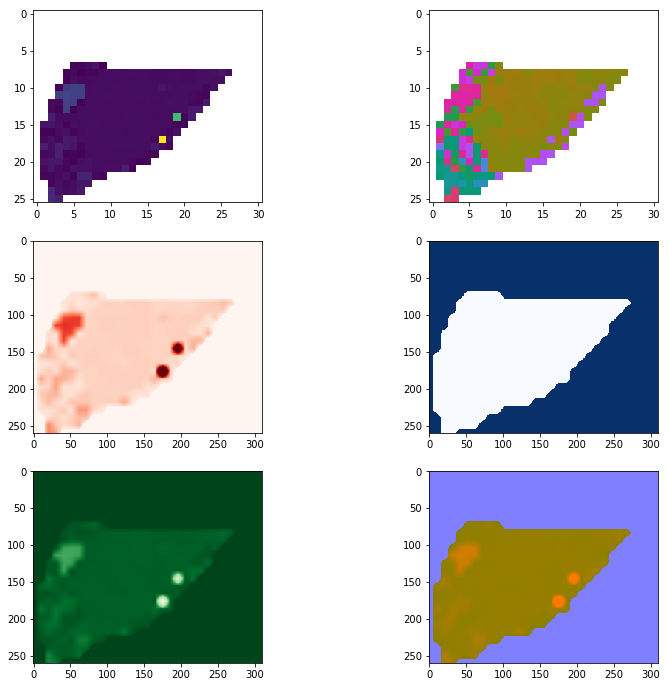

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(13, 12))
axes[0, 0].imshow(wave_period)
axes[0, 1].imshow(wave_angle, cmap=cmocean.cm.phase)
axes[1, 0].imshow(R, cmap='Reds')
axes[1, 1].imshow(B, cmap='Blues')
axes[2, 0].imshow(G, cmap='Greens')
axes[2, 1].imshow(RGB)